In [122]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pystan
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
df1 = pd.read_csv("input/data-attendance-1.txt")

In [3]:
df1.head(2)

,A,Score,Y
0,0,69,0.286
1,1,145,0.196


In [4]:
#http://sinhrks.hatenablog.com/entry/2016/11/01/075527から拝借
class Dispatcher(object):
    
    def __init__(self, fontsize=20, alpha=0.6, cmap='RdBu', threshold=10):
        self.fontsize = fontsize
        self.alpha = alpha
        self.cmap = plt.get_cmap(cmap)
 
        # 離散値 / 連続値とみなす閾値
        self.threshold = threshold
        
    def comb(self, x_series, y_series, label=None, color=None):
        """ 下三角部分のプロット """       

        x_nunique = x_series.nunique()
        y_nunique = y_series.nunique()

        if x_nunique < self.threshold and y_nunique < self.threshold:
            # 離散値 x 離散値のプロット
            return self._dd_plot(x_series, y_series, label=label, color=color)
        
        elif x_nunique < self.threshold or y_nunique < self.threshold:
            # 離散値 x 連続値のプロット
             return self._dc_plot(x_series, y_series, label=label, color=color)
            
        else:
            # 連続値 x 連続値のプロット
            return plt.scatter(x_series, y_series, label=label, color=color)

    def _dd_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 離散値のプロット """

        # x, y 各組み合わせの個数を集計
        total = y_series.groupby([x_series, y_series]).count()

        # x, y軸をプロットする位置を取得
        xloc = total.index.labels[0] 
        yloc = total.index.labels[1] 
        values = total.values

        ax = plt.gca()
        for xp, yp, vp in zip(xloc, yloc, values):
            ax.annotate(vp, (xp, yp), fontsize=self.fontsize,
                        ha='center', va='center')

        # 組み合わせの個数を散布図としてプロット
        size = values / (values.max() * 1.1) * 100 * 20
        ax.scatter(xloc, yloc, s=size, label=label, color=color)
        ax.set_ylim(yloc[0] - 0.5, yloc[-1] + 0.5)
        
    def _dc_plot(self, x_series, y_series, label=None, color=None):
        """ 離散値 x 連続値のプロット """

        if y_series.nunique() < x_series.nunique():
            # y軸が離散値の場合は、x, yを入替
            # 水平方向に箱ひげ図をプロット
            x_series, y_series = y_series, x_series
            vert = False
        else:
            vert = True

        xlab, xun = pd.factorize(x_series) # return the index of unique values list, unique values

        # 箱ひげ図用のデータの準備
        data = []
        for i, g in y_series.groupby(xlab):
            data.append(g) 
            
        ax = plt.gca()
        ax.boxplot(data, positions=np.arange(len(data)), vert=vert)

        # 散布図をプロット
        xloc = xlab + np.random.normal(scale=0.05, size=len(xlab))
        if not vert:
            y_series, xloc = xloc, y_series

        ax.scatter(xloc, y_series, label=label, color=color,
                   alpha=self.alpha)


    def ellipse(self, x_series, y_series, label=None, color=None):
        """ 上三角部分のプロット """        

        from matplotlib.patches import Ellipse
        
        # 相関係数を楕円としてプロット
        r = x_series.corr(y_series)
        c = self.cmap(0.5 * (r + 1))

        ax = plt.gca()
        ax.axis('off')
        ax.add_artist(Ellipse(xy=[.5, .5], width=np.sqrt(1 + r), height=np.sqrt(1 - r),
                              angle=45, facecolor=c, edgecolor='none', transform=ax.transAxes))
        ax.text(.5, .5, '{:.0f}'.format(r * 100), fontsize=self.fontsize,
                ha='center', va='center', transform=ax.transAxes)

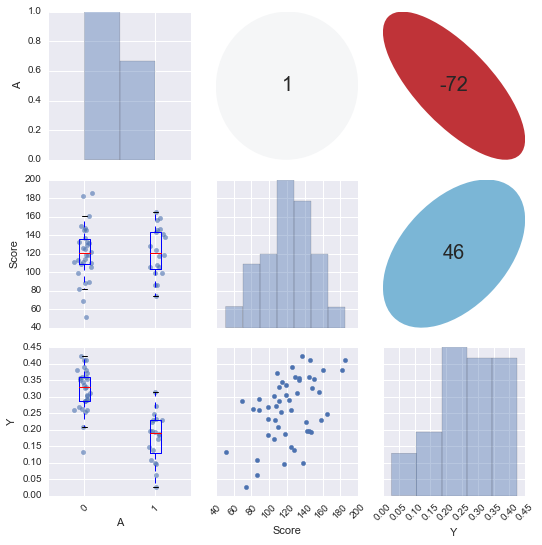

In [5]:
g = sns.PairGrid(df1, diag_sharey=False)
d = Dispatcher()
# 対角成分
g.map_diag(sns.distplot, kde=False)
# 下三角成分
g.map_lower(d.comb)
# 上三角成分
g.map_upper(d.ellipse)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

In [62]:
# 書籍通りだと、データが不十分そうなので、データ追加
Score_new = np.arange(50,200)
N_new = len(Score_new)
data = {'N':len(df1), 'N_new': N_new,'A':df1["A"], 'Score':df1["Score"]/200, 'Score_new': Score_new/200,'Y':df1["Y"]}
fit = pystan.stan("stan/model5-3.stan",  data=data, seed=1234)

In [63]:
fit

Inference for Stan model: anon_model_6d8c7e9bab1e9f0233994ed9355da70d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1             0.12  1.2e-3   0.03   0.06    0.1   0.13   0.15   0.19    775    1.0
b2            -0.14  5.0e-4   0.02  -0.17  -0.15  -0.14  -0.13  -0.11    929    1.0
b3             0.32  1.9e-3   0.05   0.22   0.29   0.32   0.36   0.43    785    1.0
sigma          0.05  2.0e-4 5.7e-3   0.04   0.05   0.05   0.06   0.06    847    1.0
mu[0]          0.24  6.1e-4   0.02    0.2   0.22   0.24   0.25   0.27    810    1.0
mu[1]          0.21  4.2e-4   0.01   0.19   0.21   0.21   0.22   0.24   1038    1.0
mu[2]          0.33  2.9e-4 9.7e-3   0.31   0.32   0.33   0.33   0.35   1114    1.0
mu[3]          0.12  4.9e-4   0.01   0.09   0.11   0.12   0.13   0.15    922    1.0
mu[4]          0.24  5.0e-4   0.02    0.2   0.23   0.24

#### 5.1.8 図によるモデルのチェック

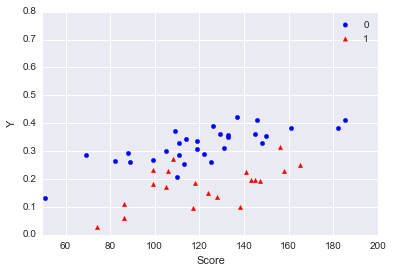

In [64]:
idx_a0 = df1.A == 0
df_a0 = df1[idx_a0]
ax1= plt.scatter(df_a0.Score, df_a0.Y, marker="o", color="b",label="0")
idx_a1 = df1.A == 1
df_a1 = df1[idx_a1]
ax1= plt.scatter(df_a1.Score, df_a1.Y, marker="^", color="r",label="1")
ax1= plt.xlim(50,200)
ax1= plt.ylim(0,0.8)
ax1= plt.xlabel("Score")
ax1= plt.ylabel("Y")
ax1= plt.legend(loc="best")

書籍データ誤り？

In [65]:
ms = fit.extract()

In [66]:
y0_pred = ms["y0_pred"].T
y1_pred = ms["y1_pred"].T

In [67]:
y0_pred.shape

(150, 4000)

In [68]:
N_mcmc = len(ms["lp__"])
x_range = np.arange(0,200,200)
b1 = np.median(ms["b1"])
b2 = np.median(ms["b2"])
b3 = np.median(ms["b3"])
pred0_low80 = []
pred0_upp80 = []
pred0_med = []
pred1_low80 = []
pred1_upp80 = []
pred1_med = []
for _y0, _y1 in zip(y0_pred,y1_pred):
    
    pred0_med.append(np.median(_y0)), pred1_med.append(np.median(_y1))
    pred0_80, pred1_80 = np.percentile(_y0,[10,90]), np.percentile(_y1,[10,90])
    pred0_low80.append(pred0_80[0]), pred1_low80.append(pred1_80[0])
    pred0_upp80.append(pred0_80[1]), pred1_upp80.append(pred1_80[1])

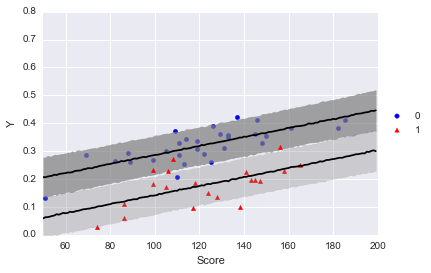

In [72]:
idx_a0 = df1.A == 0
df_a0 = df1[idx_a0]
idx_a1 = df1.A == 1
df_a1 = df1[idx_a1]
ax1= plt.scatter(df_a0.Score, df_a0.Y, marker="o", color="b",label="0")
ax1= plt.plot(Score_new, pred0_med, "-", color="black")
ax1= plt.fill_between(Score_new, pred0_low80, pred0_upp80, color='gray', alpha=0.7) 
ax1= plt.scatter(df_a1.Score, df_a1.Y, marker="^", color="r",label="1")
ax1= plt.plot(Score_new, pred1_med, "-", color="black")
ax1= plt.fill_between(Score_new, pred1_low80, pred1_upp80, color='gray', alpha=0.3) 
ax1= plt.xlim(50,200)
ax1= plt.ylim(0,0.8)
ax1= plt.xlabel("Score")
ax1= plt.ylabel("Y")
ax1= plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

##### fig 5.3 

In [75]:
y_obsv = df1.Y
y_pred = ms["y_pred"]

In [80]:
y_pred.shape

(4000, 50)

In [84]:
quantile = [10, 50, 90]
colname = ['p' + str(x) for x in quantile]
df_qua = pd.DataFrame(np.percentile(ms['y_pred'], q=quantile, axis=0).T, columns=colname)
d = pd.concat([df1, df_qua], axis=1)
d0 = d[d.A == 0]
d1 = d[d.A == 1]

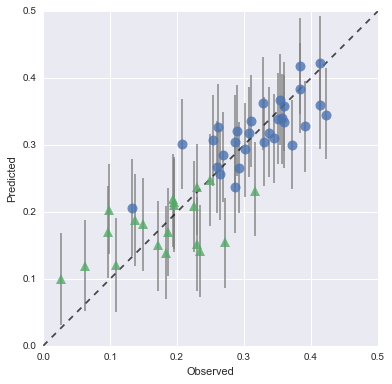

In [87]:
palette = sns.color_palette()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot([0,0.5], [0,0.5], 'k--', alpha=0.7)
ax.errorbar(d0.Y, d0.p50, yerr=[d0.p50 - d0.p10, d0.p90 - d0.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[0], alpha=0.8, marker='o')
ax.errorbar(d1.Y, d1.p50, yerr=[d1.p50 - d1.p10, d1.p90 - d1.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[1], alpha=0.8, marker='^')
ax.set_aspect('equal')
ax.set_xlim(0, 0.5)
ax.set_ylim(0, 0.5)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')

##### fig. 5.4(若干本当異なる)

/Users/yuki.ohnishi/.pyenv/versions/analysis/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


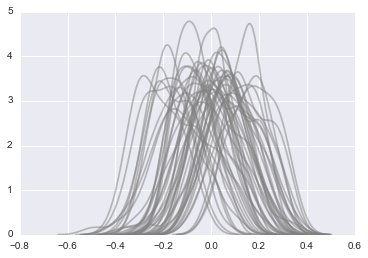

In [102]:
y_tmp_for_map = []
for n in range(len(df1)):
    y_pred_tmp = y_pred[n]
    y_obsv_tmp = y_obsv[n]
    y_tmp = y_obsv_tmp - y_pred_tmp
    y_tmp_for_map.append(y_tmp)
    sns.kdeplot(y_tmp,  kernel="gau", color="gray", alpha=0.5)

In [106]:
# map推定値を求める。もっとスマートな方法はないものか。
import statsmodels.api as sm
map_list = []
for arr in y_tmp_for_map:
    kde = sm.nonparametric.KDEUnivariate(arr)
    kde.fit()
    val_peak = kde.support[kde.density.argmax()]
    map_list.append(val_peak)

/Users/yuki.ohnishi/.pyenv/versions/analysis/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


/Users/yuki.ohnishi/.pyenv/versions/analysis/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


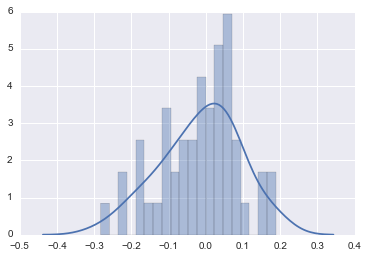

In [118]:
sns.distplot(map_list,bins=20)

##### fig. 5.5

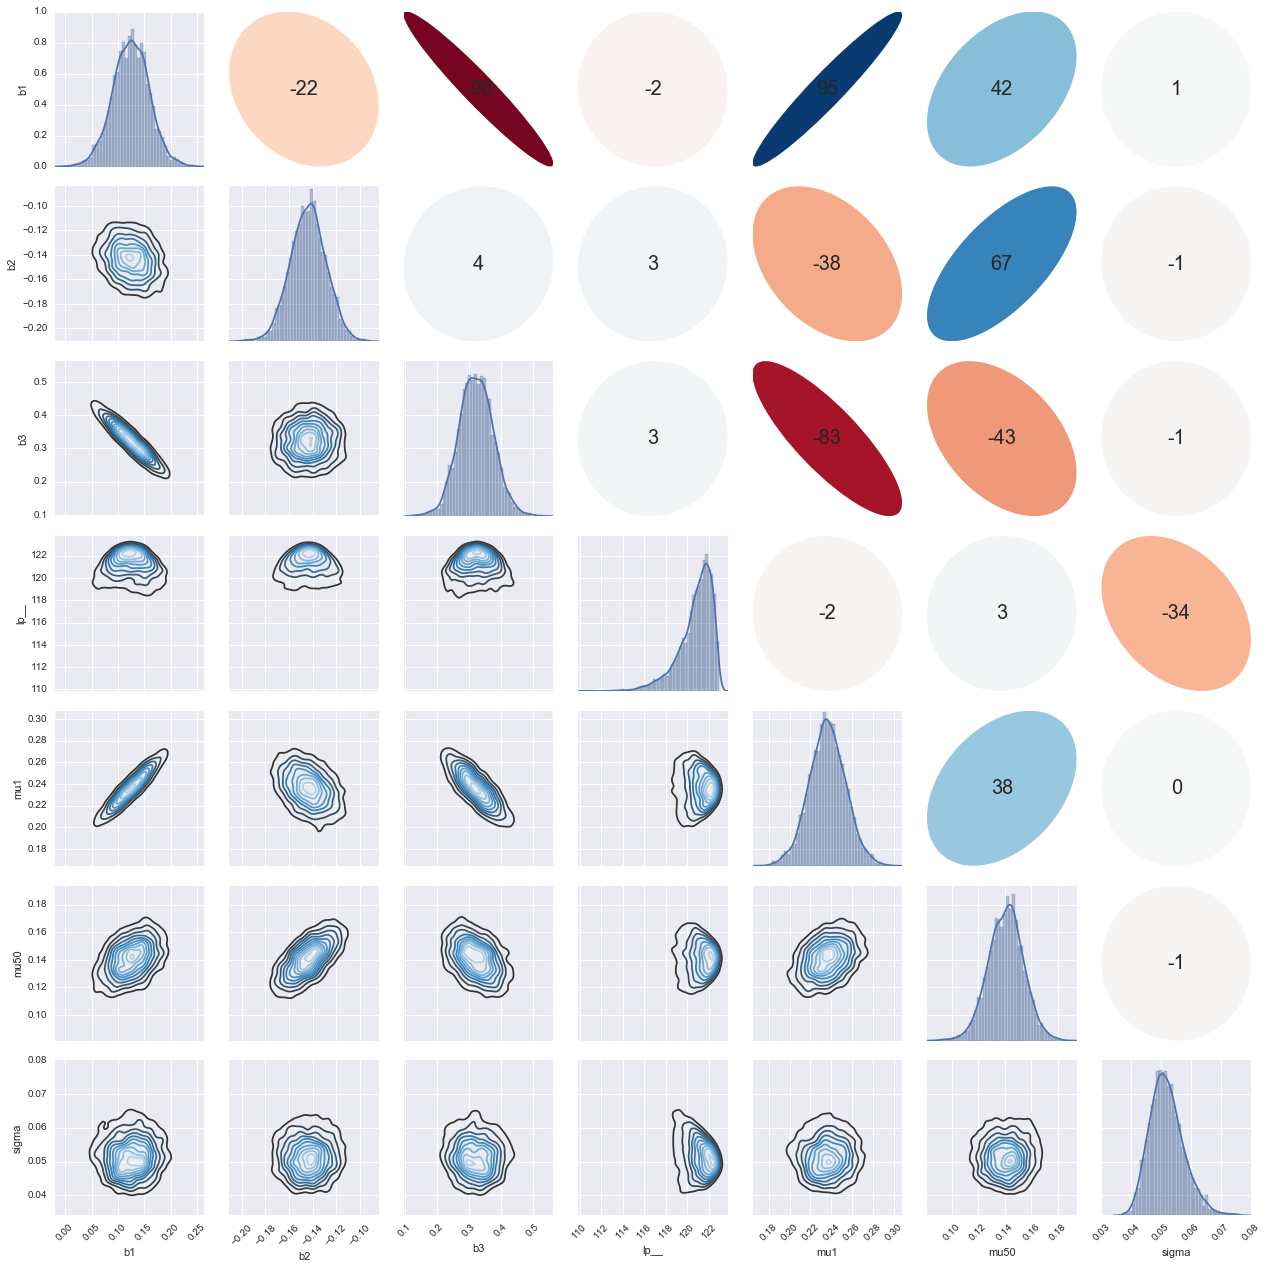

In [164]:
df_tmp = pd.DataFrame({"b1": ms["b1"], "b2": ms["b2"], "b3": ms["b3"], "sigma": ms["sigma"], "mu1": ms["mu"].T[0], "mu50": ms["mu"].T[49], "lp__":ms["lp__"]})
g = sns.PairGrid(df_tmp, diag_sharey=False)
d = Dispatcher()
# 対角成分
g.map_diag(sns.distplot)
# 下三角成分
g.map_lower(sns.kdeplot, cmap='Blues_d')
# 上三角成分
g.map_upper(d.ellipse)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

### 5.2 二項ロジスティック回帰

In [130]:
df2 = pd.read_csv("input/data-attendance-2.txt")
df2["ratio"] = df2.Y / df2.M

In [131]:
df2.head()

,PersonID,A,Score,M,Y,ratio
0,1,0,69,43,38,0.883721
1,2,1,145,56,40,0.714286
2,3,0,125,32,24,0.750000
3,4,1,86,45,33,0.733333
4,5,1,158,33,23,0.696970


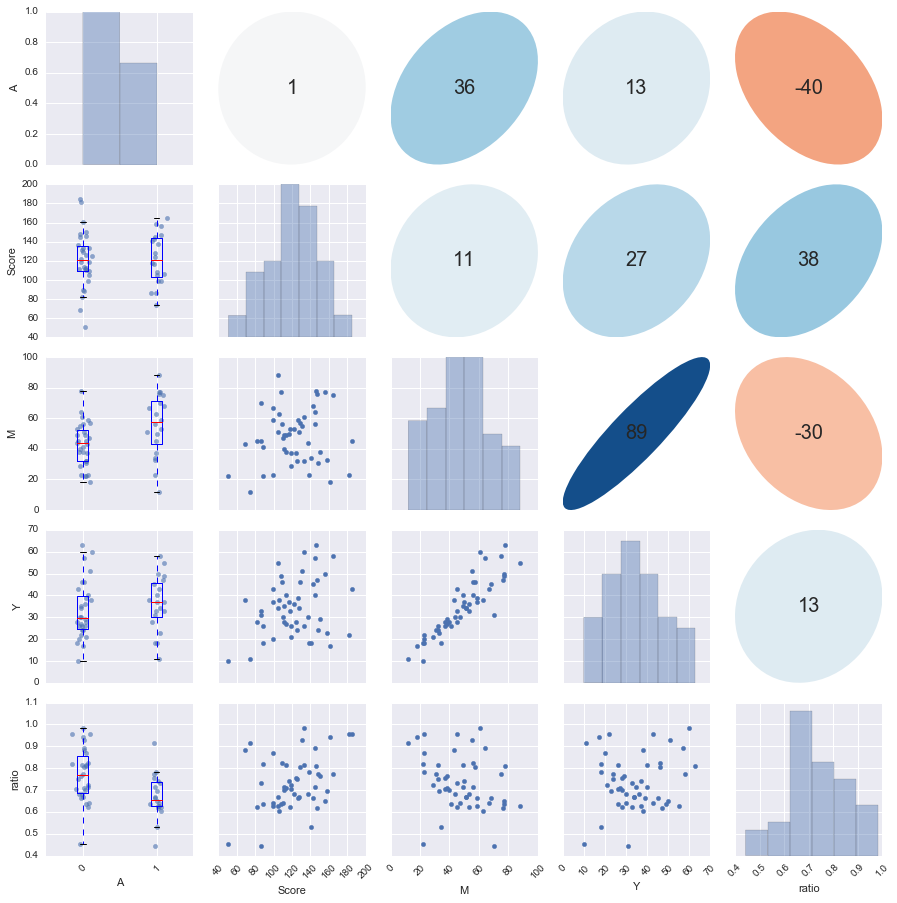

In [132]:
g = sns.PairGrid(df2.iloc[:,1:], diag_sharey=False)
d = Dispatcher()
# 対角成分
g.map_diag(sns.distplot, kde=False)
# 下三角成分
g.map_lower(d.comb)
# 上三角成分
g.map_upper(d.ellipse)
for ax in g.axes.flat:  
    plt.setp(ax.get_xticklabels(), rotation=45)

In [169]:
data54 = {"N":len(df2), "A":df2.A, "Score":df2.Score/200, "Y":df2.Y, "M":df2.M}
fit52 = pystan.stan(file="stan/model5-4.stan", data=data54, seed=1234)

In [170]:
fit52

Inference for Stan model: anon_model_bc0f2141b5b3bd53d2d0372f0c2c476d.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

             mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
b1           0.09  9.2e-3   0.22  -0.34  -0.06   0.09   0.23   0.52    580   1.01
b2          -0.62  3.3e-3   0.09   -0.8  -0.69  -0.62  -0.56  -0.44    836    1.0
b3           1.91    0.01   0.36   1.21   1.67   1.91   2.14   2.61    599   1.01
q[0]         0.68  9.8e-4   0.02   0.63   0.66   0.68   0.69   0.73    620    1.0
q[1]          0.7  5.6e-4   0.02   0.67   0.69    0.7   0.71   0.73    851    1.0
q[2]         0.78  3.8e-4   0.01   0.76   0.77   0.78   0.79   0.81   1022    1.0
q[3]         0.57  7.9e-4   0.02   0.53   0.56   0.57   0.59   0.61    771    1.0
q[4]         0.73  6.7e-4   0.02   0.69   0.71   0.73   0.74   0.76    755    1.0
q[5]          0.8  3.8e-4   0.01   0.77   0.79    0.8    0.8   0.82   103

In [179]:
ms52 = fit52.extract()

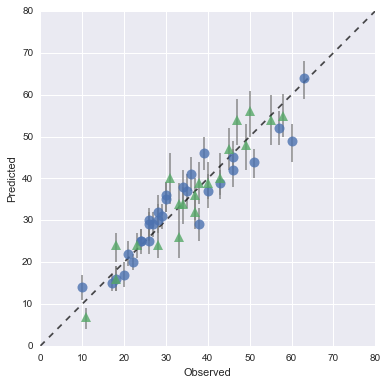

In [180]:
quantile = [10, 50, 90]
colname = ['p' + str(x) for x in quantile]
df_qua = pd.DataFrame(np.percentile(ms52['y_pred'], q=quantile, axis=0).T, columns=colname)
d = pd.concat([df2, df_qua], axis=1)
d0 = d[d.A == 0]
d1 = d[d.A == 1]
palette = sns.color_palette()
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1)
ax.plot([0,80], [0,80], 'k--', alpha=0.7)
ax.errorbar(d0.Y, d0.p50, yerr=[d0.p50 - d0.p10, d0.p90 - d0.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[0], alpha=0.8, marker='o')
ax.errorbar(d1.Y, d1.p50, yerr=[d1.p50 - d1.p10, d1.p90 - d1.p50],
    fmt='o', ecolor='gray', ms=10, mfc=palette[1], alpha=0.8, marker='^')
ax.set_aspect('equal')
ax.set_xlim(0, 80)
ax.set_ylim(0, 80)
ax.set_xlabel('Observed')
ax.set_ylabel('Predicted')


### 5.3 ロジスティック回帰